---
title: "3.3 Case Study: Language Modeling and Inner Products"
subject: Inner Products and Norms
subtitle: How modern language modeling boils down to inner products
short_title: "3.3 Case Study: Language Modeling and Inner Products"
authors:
  - name: Thomas Zhang & Renukanandan Tumu
    affiliations:
      - Dept. of Electrical and Systems Engineering
      - University of Pennsylvania
    email: ttz2@seas.upenn.edu
license: CC-BY-4.0
keywords:
math:
  '\vv': '\mathbf{#1}'
  '\bm': '\begin{bmatrix}'
  '\em': '\end{bmatrix}'
  '\R': '\mathbb{R}'
  '\calS': '\mathcal{S}'
  '\Sin': '\mathcal{S}_{\mathrm{in}}'
  '\Sout': '\mathcal{S}_{\mathrm{out}}'
  '\Enc': '\mathrm{Enc}'
  '\Dec': '\mathrm{Dec}'
  '\vbar': '\rule[-1ex]{0.5pt}{2.5ex}'
  '\hbar': '\rule[.5ex]{2.5ex}{0.5pt}'
---

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/nikolaimatni/ese-2030/HEAD?labpath=/02_Ch_3_Inner_Products_and_Norms/042a-NLP-case-study.ipynb)

## Prelude

One of the most intensely active application areas of machine learning is natural language processing (NLP). Correspondingly, many of the go-to demonstrations of machine learning's success are related to language modeling, most prominent of which are the myriad AI assistants spawning in the wake of ChatGPT.

From a beginner's point of view, the eventful history of technological developments that lead to these extraordinary products can appear daunting and opaque. The goal of this case study is to demystify the precursor techniques leading up to ChatGPT (and co.), and to demonstrate that many of the intuitions that motivate these technologies essentially boil down to the linear algebra that we've already seen!

## Part 0: Language Modeling Tasks, Abstractified

Before pulling back the curtain, let us first define at a high-level what a language modeling task might look like. Language translation is a typical language modeling task: given an input sentence in French, produce an output sequence in English that best matches the meaning of the input. Another example is question-and-answering: given a chunk of text describing a request, output a paragraph that best fulfills the request. Q&A indeed constitutes a large part of ChatGPT's utility, and is quite a flexible paradigm in general, e.g. one can formulate translation into a request.

Abstractly, the goal of a language model is therefore to take an input sequence and somehow produce a predictive output sequence. However, this leaves a lot of the magic unexplained, especially concerning context: how in the world does a language model "understand" or "measure" the context between words in order to produce a sensible response? This can be a hard problem, even for humans, since key context-determiners can be sparse yet remain relevant throughout a long history (think about those literary analyses you've written in writing classes).

Toward addressing this issue, the great majority of modern language models (and ML more broadly) follow a common **"encoder-decoder"** template. Namely, an encoder takes in the input sequence and embeds it into a latent (vector) space, where notions of "similarity" become quantifiable *mathematically* (rather than *semantically* in word/sentence form), and a decoder which takes the vector in latent space and transforms it back into an output sequence. The precise way that the encoders and decoders operate and interact is characterized by the **model architecture**, which we will return to later. For now, we can view a language model abstractly as composing a black-box encoder with a decoder, as pictured below.

```{figure} 042a-NLP/encoder_decoder.png
:width: 50%
:alt: A visualization of an encoder-decoder architecture.
:align: "center"
An encoder-decoder language model for translating French to English. [Image credit](https://jalammar.github.io/illustrated-transformer/)

```

For mathematical concreteness, let $\Sin$ be the set of input sequences, $\Sout$ be the set of output sequences, and $\R^{\ell}$ be the $\ell$-dimensional latent space. Then, we may view simplistically the encoder and decoder as functions
\begin{align}\label{def:enc_dec}
&\Enc: \Sin \to \R^{\ell} \\
&\Dec: \R^{\ell} \to \Sout.
\end{align}

## Part 1: understanding Word2Vec

Let us start our journey with a discussion of encoders. A perhaps surprising revelation during the rise of deep learning was the fact that an encoder obtained through training on a set of particular tasks (e.g. translation, next-word-prediction, fill-in-the-blank), would be useful for tasks the encoder was *never trained on*. In other words, for a new task, $\Enc$ can be used out-of-the-box, and one would only need to generate a new decoder $\Dec$ to execute the new task. This should be very surprising: why should the latent space that is performant for, e.g., translation be at all useful for fill-in-the-blank? This implies that a sufficiently diverse training regimen might encourage the latent space mapped to by the Encoder to capture some *general* structure in the data.

A landmark project demonstrating the surprising generality of language models is [Word2Vec](https://arxiv.org/abs/1301.3781), dating all the way back to 2013! Just as we previewed, Word2Vec involves an Encoder-Decoder model that was trained on just two natural language processing tasks, Continuous Bag-of-Words ("CBOW") and Continuous Skip-Gram ("CSG"), to be defined shortly. As we will soon see, despite the narrow scope of tasks Word2Vec was trained on, the latent space generated by its encoder has some intriguing properties...

Before demonstrating Word2Vec's capabilities, let us take apart the key components that make it up: 1. representing word inputs mathematically (and defining CBOW/CSG), 2. transforming inputs into vectors in latent space, 3. converting latent vectors back into word outputs.

### Step 1: how to convert language to mathematical objects?

A prerequisite before applying any mathematical or numerical method onto natural language is to convert said language into a numerical format. One of the simplest representations of words (or categorical variables in general) is the "one-hot encoding".

:::{prf:definition} One-Hot Encoding
:label: onehot_encoding

Given an *ordered* (e.g. lexicographically) vocabulary of $N$ words, the *one-hot encoding* of the $i$th word is a vector $e_i \in \R^N$, where the vector $e_i$ has $1$ for its $i$th entry, and $0$ for all other entries.
:::

As an example, let's say we have a toy vocabulary composed of three words in alphabetical order: $\{\mathrm{``Apple", \;``Banana", \;``Cherry"}\}$. Then, the one-hot encodings of each word would be
\begin{align*}
&\mathrm{``Apple"} \to \bm 1 & 0 & 0 \em^\top \\
&\mathrm{``Banana"} \to \bm 0 & 1 & 0 \em^\top \\
&\mathrm{``Cherry"} \to \bm 0 & 0 & 1 \em^\top.
\end{align*}

Therefore, the one-hot encoding converts each word to a vector. This brings us to the language tasks that Word2Vec is trained on: continuous bag-of-words and continuous skip-gram. Despite their esoteric names, CBOW and CSG are rather simple tasks and are opposite of each other. 


#### Continuous Bag-of-Words

For CBOW, the goal is to predict a word given the words surrounding it (disregarding order, hence "bag" of words). As an example, given the sentence "the quick brown fox jumps over the lazy dog", if we omit the word "jumps", the goal of CBOW is to predict the most likely word given the bag of surrounding words {"brown", "dog", "fox", "over", "lazy", "quick", "the"}. The number of words surrounding the to-be-predicted central word (also known as the "window size") is an important user-specified parameter; too few words and the problem is ambiguous and fundamentally hard, too many and the problem becomes very computationally expensive and also fundamentally hard (imagine predicting a single word inside a news article).

One may now be wondering: how do you encode a bag of words via the one-hot encoding, which only encodes a single word? An extremely simple solution is to add up the one-hot encodings of each word. One can verify that this corresponds to a vector whose entries are the count of each word showing up in the input. For example, the following phrases from our toy vocabulary would be encoded as:
\begin{align*}
&\mathrm{``Apple\;Cherry\;Apple"} \to \bm 2 & 0 & 1 \em^\top \\
&\mathrm{``Cherry\; Banana\; Cherry\; Apple\; Banana\; Banana"} \to \bm 1 & 3 & 2 \em^\top.
\end{align*}
Depending on the exact model, the vectors may be further divided by the number of words in the window, such that the entries of the vector add up to $1$.

#### Continuous Skip-Gram

The goal of CSG is the exact opposite of CBOW. Where CBOW involves predicting a word from the words surrounding it, the goal of CSG is to predict the surrounding words given the central word. This may sound like a harder problem, and it typically is. Therefore, Word2Vec uses both CSG and CBOW as prediction tasks to learn the encoder and decoder. We will skip discussion of how Word2Vec "learns" the prediction task, which is more topical for when we cover optimization, or for a dedicated machine learning course.

```{figure} 042a-NLP/cbow_csg.png
:width: 50%
:alt: A visualization of CBOW and CSG.
:align: "center"
[Image credit](https://arxiv.org/abs/1301.3781)

```

### Step 2: transforming inputs into latent vectors

A critical component of Word2Vec is the encoder, which transforms the inputs (in the one-hot encoding format as discussed), into a latent vector. However, one may ask, why is going through the encoder-decoder route even necessary? We can view this from computational lens. Take the Continuous Skip-Gram task: given a vocabulary of size $N$, for each word $\mathrm{word}[i]$, we can sweep through the database (e.g. Wikipedia) and add up all the words that ever show up within a, say, $5$ word radius of every occurrence of $\mathrm{word}[i]$. After dividing by the total word count, this corresponds to the proportion of times every other word shows up in a radius around $\mathrm{word}[i]$ in the database. Therefore, for each word, we associate a vector of $\R^N$. Therefore, this look-up table will have $N \times N = N^2$ entries to store ($\R^N$ vector for each of $N$ words). For a moderately sized vocabulary of $10000$ words, this table will already have $100$ million entries. For the full English vocabulary of ~$600000$ words, this adds up to ~$3.6$ trillion entries! And this is ignoring the computational cost of actually computing these tables. Therefore, it is generally not palatable to compute or store a full look-up table, not to mention wasteful! For example, we might expect that entries to corresponding to rare words (comprising the majority of English) will often be $0$.

To circumvent this computational inefficiency, the idea that Word2Vec proposes is to encode each word to a latent vector of dimension $\R^\ell$, and from an $\R^\ell$ embedding we decode an output in $\R^N$ (more on this later). Therefore, storage-wise, the encoder involves $N$ vectors of dimension $\ell$, and the decoder roughly involves a matrix going from $\R^\ell$ to $\R^N$, thus adding up to a storage requirement of approximately
\begin{align*}
    N \ell + \ell N = 2N\ell.
\end{align*}
The key here is that $\ell$ can usually be chosen to stay relatively small and constant, e.g. $50$ or $100$. Therefore, plugging in $\ell = 100$ and the vocab sizes from earlier, we see a huge improvement in efficiency that only gets more dramatic as $N$ gets larger:
\begin{align*}
N = 10,000: \quad &N^2 = 100,000,000, \;2N\ell = 2,000,000 \\
N = 600,000: \quad &N^2 = 3.6e12, \;2N\ell = 120,000,000.
\end{align*}

This is a good time to discuss the architecture of Word2Vec's encoder and decoder. Considering the encoder-decoder composed together, Word2Vec uses a fundamental type of neural network called the Multi-Layer Perceptron (MLP), which will be described in much greater detail near the end of this course in [Chapter 12](../11_Ch_12_Optimization/134-SGD.ipynb). In particular, Word2Vec uses an MLP with one *hidden layer*.

:::{prf:definition} Word2Vec MLP (redux)
:label: word2vec-mlp
Consider a vocabulary size $N$. Let $\bold x_{\mathrm{in}}$ and $\bold x_{\mathrm{out}}$ denote the input and output vectors in $\R^N$. Given a hidden layer dimension of $\ell$, a one-hidden-layer MLP generates $\bold x_{\mathrm{out}}$ from $\bold x_{\mathrm{in}}$ via:
\begin{align*}
    \bold x_{\mathrm{out}} &= f(\bold W_{\mathrm{out}} \; \sigma(\bold W_{\mathrm{in}} \; \bold x_{\mathrm{in}} ) ),
\end{align*}
where $W_{\mathrm{out}} \in \R^{N \times \ell}$, $W_{\mathrm{in}} \in \R^{\ell \times N}$. $\sigma(\cdot): \R^{\ell} \to \R^{\ell}$ is a fixed, non-linear function that acts on each entry in $\R^{\ell}$, for example:
\begin{align*}
    \sigma\left(\bm z_1 \\ \vdots \\ z_\ell \em \right) = \bm \tanh(z_1) \\ \vdots \\ \tanh(z_\ell) \em,
\end{align*}
which in this case [$\tanh$](https://en.wikipedia.org/wiki/Hyperbolic_functions) sends each entry to a normalized range between $[-1, 1]$. The importance of non-linearity here will be expounded much later in [Chapter 12](../11_Ch_12_Optimization/134-SGD.ipynb). Lastly, $f(\cdot): \R^{N} \to \R^N$ is a particular entry-wise function that will be discussed in the next section.

Therefore, recalling our [abstract definition](#def:enc_dec) of encoder and decoder, we may view the Word2Vec MLP as:
\begin{align*}
    \mathrm{Enc}(\bold x_{\mathrm{in}}) &= \sigma(\bold W_{\mathrm{in}} \; \bold x_{\mathrm{in}} ) \in \R^{\ell} \\
    \mathrm{Dec}(\bold z_{\mathrm{latent}}) &= f(\bold W_{\mathrm{out}} \; \bold z_{\mathrm{latent}}) \in \R^N.
\end{align*}
:::

Crucially, since $\sigma(\cdot), f(\cdot)$ are fixed known functions, the matrices $\bold W_{\mathrm{in}}$ and $\bold W_{\mathrm{out}}$ are what govern the behavior of Word2Vec, and precisely correspond to the storage requirement we roughly estimated just earlier: clocking in at $N \times \ell$ entries each, the number of total entries is $2N \ell$.

### Step 3: converting latent vectors to predictions

The last component of Word2Vec is the mapping from the latent vector to the final prediction, i.e. the decoder. From the [previous section](#word2vec-mlp), we know the decoder has form: $\mathrm{Dec}(\bold z_{\mathrm{latent}}) = f(\bold W_{\mathrm{out}} \; \bold z_{\mathrm{latent}})$, where $f(\cdot)$ was some unspecified function. If we had ignored $f(\cdot)$, then the output would be a matrix multiplication of the latent vector. How do we interpret this? If we recall the goal of CBOW or CSG, we want to be able to extract a predicted word or set of words. However, a vector resulting from matrix multiplication may have entries much larger than $1$, or even negative, leading to ambiguities in interpreting the output. What if we could define a function $f(\cdot)$ that normalizes these entries in a principled way? Enter the $\mathrm{Softmax}$ function.

:::{prf:definition} Softmax
:label: softmax-def

Given a vector $\bold x = \bm x_1 & \cdots & x_N \em^\top \in \R^N$, $\mathrm{Softmax}$ is defined as:
\begin{align*}
    \mathrm{Softmax}\left(\bm x_1 \\ \vdots \\ x_N \em\right) &= \bm \frac{\exp(x_1)}{\sum_{i=1}^N \exp(x_i)} \\ \vdots \\ \frac{\exp(x_N)}{\sum_{i=1}^N \exp(x_i)} \em.
\end{align*}

By definition, the output of $\mathrm{Softmax}$ satisfies the following properties: 
- Entries are always positive: $\mathrm{Softmax}(\bold x)_j = \frac{\exp(x_j)}{\sum_{i=1}^N \exp(x_i)} > 0$ for all $j = 1,\dots,N$.
- Entries sum up to $1$: $\sum_{i=1}^N \mathrm{Softmax}(\bold x)_i = \frac{\sum_{i=1}^N \exp(x_i)}{\sum_{i=1}^N \exp(x_i)} = 1$.
:::

$\mathrm{Softmax}$ gets its name by the fact that the exponential function $\exp(\cdot)$ tends to literally blow-up larger values exponentially, and thus when one entry of $\bold x$ is larger than the others, the output of $\mathrm{Softmax}(\bold x)$ is approximately the [one-hot encoding](#onehot_encoding) corresponding to coordinate of the maximal entry (thus, surly applied mathematicians might note Soft*arg*max is a more accurate name).

In [1]:
import numpy as np

def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

x = np.array([-1, 0, 1])
print("x =", x, "softmax(x) =", np.round(softmax(x), 4))

x = np.array([-1, 1, 10])
print("x =", x, "softmax(x) =", np.round(softmax(x), 4))


x = [-1  0  1] softmax(x) = [0.09   0.2447 0.6652]
x = [-1  1 10] softmax(x) = [0.000e+00 1.000e-04 9.999e-01]


The reason $\mathrm{Softmax}$ is such a crucial function here, and throughout all of machine learning, is that it turns an arbitrary vector in $\R^N$ into a very special type of vector that has non-negative entries and sums up to $1$. In particular, this implies the output is a *probability vector*.

To interpret this in our setting, consider the skip-gram task: if we input the word "the", it doesn't make much sense to confidently output a set of, say, 10 words that you expect to see around any appearance of "the", since it's such a common word that is associated with much more than any particular 10 words. One way to reflect this in the output is instead of outputting a set of words (or equivalently one-hot encodings), output a vector of *probabilities* associated with every word. Ideally, this should reflect the rate or probability that you see each word in the vicinity of "the", which is arguably a much more informative statistic.

The $\mathrm{Softmax}$ is therefore a very convenient function that automatically converts an arbitrary vector into a probability vector. Furthermore, if one *did* in fact want to extract concrete words from the output, one can simply extract the words with the highest probabilities.

## Part 2: Playing around with Word2Vec

Despite going through the explanation of how Word2Vec generates outputs from latent vectors, we note that the truly surprising part about Word2Vec is not its ability to produce CBOW or CSG outputs, but rather that the latent vector space it produces through its Encoder itself has some intriguing properties, even without considering the decoder. For the rest of this study, we will play around with the intermediate, numerical latent vector space. That is, someone on the internet has already gone through the trouble of crawling through various datasets and produced $\bold W_{\mathrm{in}}, \bold W_{\mathrm{out}}$, which allows us to directly play with the Encoder.

We start by importing a Python package `gensim` containing helpfully pretrained versions of models like Word2Vec. We will for convenience be using latent vectors generated by a related method known as [GloVe](https://nlp.stanford.edu/projects/glove/), which for all our intents are purposes is the same as Word2Vec. We note that the model we'll be using was trained on a dataset comprised of (2014) Wikipedia and a large corpus of news articles.

In [2]:
%pip install scipy==1.10.1

Note: you may need to restart the kernel to use updated packages.


In [3]:
import gensim
import numpy as np
import gensim.downloader

latent_vectors = gensim.downloader.load('glove-wiki-gigaword-50')

In [4]:
print("Latent embedding of `apple':\n", latent_vectors['apple'])
print("Latent dimension: ", np.shape(latent_vectors['apple']))

Latent embedding of `apple':
 [ 0.52042  -0.8314    0.49961   1.2893    0.1151    0.057521 -1.3753
 -0.97313   0.18346   0.47672  -0.15112   0.35532   0.25912  -0.77857
  0.52181   0.47695  -1.4251    0.858     0.59821  -1.0903    0.33574
 -0.60891   0.41742   0.21569  -0.07417  -0.5822   -0.4502    0.17253
  0.16448  -0.38413   2.3283   -0.66682  -0.58181   0.74389   0.095015
 -0.47865  -0.84591   0.38704   0.23693  -1.5523    0.64802  -0.16521
 -1.4719   -0.16224   0.79857   0.97391   0.40027  -0.21912  -0.30938
  0.26581 ]
Latent dimension:  (50,)


What's so interesting about these embeddings? For one, **linear-algebraic notions of similarity** are now sensible semantically! Before then, let us review the Euclidean dot product and generalized angles from [Chapter 3.2](./o42-angle.ipynb). Recall that the dot product can be expressed as 
\begin{align*}
    \bold v \cdot \bold w = \| \bold v \| \| \bold w \| \cos(\theta),
\end{align*}
where $\theta$ is the angle between $\bold v$ and $\bold w$. Notice that as stated, the dot product is sensitive to the length of $\bold v, \bold w$. Therefore, if we are only interested in the alignment of two vectors, it suffices only to consider the $\cos(\theta)$, which is $1$ if $\bold v$ and $\bold w$ are pointing the same direction, $-1$ if they are pointing directly opposite, and $0$ if they are perpendicular. This is often called the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity).
:::{prf:definition} Cosine similarity
:label: cosine_similarity
The cosine similarity between two vectors $\bold v, \bold w \in \R^\ell$ is defined as:
$$
    \mathrm{sim}(\bold v, \bold w) := \frac{\bold v \cdot \bold w}{\|\bold v\| \| \bold w \|} = \cos(\theta).
$$
One can verify that the cosine similarity is bounded between $[-1,1]$.
:::
Now let us print the words that are deemed "most similar" to "algebra" in the latent space and verify that the cosine similarity is indeed being used.

In [5]:
def cos_sim(v,w):
    return np.dot(v,w)/(np.linalg.norm(v)*np.linalg.norm(w))

print("Top 3 most similar words to 'algebra'")
for i in range(3):
    print(latent_vectors.most_similar('algebra')[i])

print("\nCosine simlarity('algebra', 'geometry'):", cos_sim(latent_vectors['algebra'], latent_vectors['geometry']))
print("Cosine simlarity('algebra', 'algebraic'):", cos_sim(latent_vectors['algebra'], latent_vectors['algebraic']))
print("Cosine simlarity('algebra', 'homological'):", cos_sim(latent_vectors['algebra'], latent_vectors['homological']))

Top 3 most similar words to 'algebra'
('geometry', 0.8046252727508545)
('algebraic', 0.7837221622467041)
('homological', 0.7524771094322205)

Cosine simlarity('algebra', 'geometry'): 0.8046252
Cosine simlarity('algebra', 'algebraic'): 0.7837221
Cosine simlarity('algebra', 'homological'): 0.75247705


This confirms that the notion of similarity that `gensim` uses here is exactly the cosine similarity. Now, we can try some cool stuff. Let's first try *analogies*. One might crudely say that an analogy can be subtracting the particular object away, leaving only the essence of the comparison, then adding back a different object to yield a new comparison. For example, "big is to biggest as fast is to..." clearly should be completed with "fastest". What if we measure the similarity of $\mathrm{Enc}(\text{biggest}) - \mathrm{Enc}(\text{big}) + \mathrm{Enc}(\text{fast})$ to $\mathrm{Enc}(\text{fastest})$?

In [6]:
vec = latent_vectors['biggest'] - latent_vectors['big'] + latent_vectors['fast']
print("Similarity between vector analogy and `fastest':", cos_sim(vec, latent_vectors['fastest']))

print("\nBenchmark against most similar words to 'fastest' in dataset")
for i in range(3):
    print(latent_vectors.most_similar('fastest')[i])

Similarity between vector analogy and `fastest': 0.7088693

Benchmark against most similar words to 'fastest' in dataset
('slowest', 0.7464630007743835)
('jump', 0.7409392595291138)
('clocked', 0.7197282910346985)


Not bad! Let's go crazy with some more analogies

In [7]:
print("'A man is to a king as a woman is to a...'")
vec = latent_vectors['king'] - latent_vectors['man'] + latent_vectors['woman']
print("Similarity between vector analogy and 'queen':", cos_sim(vec, latent_vectors['queen']))

print("\n'France is to Paris as Germany is to...'")
vec = latent_vectors['paris'] - latent_vectors['france'] + latent_vectors['germany']
print("Similarity between vector analogy and 'Berlin':", cos_sim(vec, latent_vectors['berlin']))
print("Similarity between vector analogy and 'Munich':", cos_sim(vec, latent_vectors['munich']))
print("Similarity between vector analogy and 'Frankfurt':", cos_sim(vec, latent_vectors['frankfurt']))

print("\nFailed example 1: 'a point to a line as a line is to a...'")
vec = latent_vectors['line'] - latent_vectors['point'] + latent_vectors['line']
print("Similarity between vector analogy and 'plane':", cos_sim(vec, latent_vectors['plane']))
print("\nFailed example 2: 'Hand is to palm as a foot is to...'")
vec = latent_vectors['palm'] - latent_vectors['hand'] + latent_vectors['foot']
print("Similarity between vector analogy and 'sole':", cos_sim(vec, latent_vectors['sole']))

'A man is to a king as a woman is to a...'
Similarity between vector analogy and 'queen': 0.86095804

'France is to Paris as Germany is to...'
Similarity between vector analogy and 'Berlin': 0.91814876
Similarity between vector analogy and 'Munich': 0.8120746
Similarity between vector analogy and 'Frankfurt': 0.81840956

Failed example 1: 'a point to a line as a line is to a...'
Similarity between vector analogy and 'plane': 0.373825

Failed example 2: 'Hand is to palm as a foot is to...'
Similarity between vector analogy and 'sole': 0.05489441


(For the failed examples, why do you think these didn't work? Recall that the data this model was trained on came from Wikipedia and news articles)

For the last demonstration we show what happens when we add more context words together.

In [8]:
print("Similarity('linear', 'matrix'):", 
      cos_sim(latent_vectors['linear'], latent_vectors['matrix']))
print("Similarity('linear'+'algebra', 'matrix'):", 
      cos_sim(latent_vectors['linear']+latent_vectors['algebra'], latent_vectors['matrix']))
print("Similarity('linear'+'algebra', 'matrix'+'theory'):",
      cos_sim(latent_vectors['linear']+latent_vectors['algebra'],
              latent_vectors['matrix'] + latent_vectors['theory']))

Similarity('linear', 'matrix'): 0.7481152
Similarity('linear'+'algebra', 'matrix'): 0.7735517
Similarity('linear'+'algebra', 'matrix'+'theory'): 0.83641165


These examples demonstrate the expressivity of a latent vector space generated by a Word2Vec encoder. We note that these properties should be quite surprising: the goal of the Word2Vec model is to predict words--at no point in producing the model is it enforced that the latent space should reflect semantic structure linear-algebraically.

## Part 3: Attention! A peek into the inner workings of (chat)GPT and family

Now having spent significant effort setting up and exploring a progenitor to modern language models, we actually already have much of what we need to understand the basic workings of the fundamental component of said modern language models, that is, the [**attention mechanism**](https://en.wikipedia.org/wiki/Attention_(machine_learning)).

The linear algebraic structure displayed by Word2Vec is impressive, but we see that it inevitably "fails" on certain analogies. In some sense, it is not surprising that Word2Vec doesn't reflect these analogies, since the tasks it is trained on do not take much *context* and *temporality* into account; e.g. CBOW is basically tossing an unordered set of words and asking to predict the most likely word to be associated with them. This is inherently an ambiguous problem without careful treatment of context: as we all have likely experienced, the same set of words can imply very different things depending on their ordering and relative frequency. Furthermore, Word2Vec's encoder associates a fixed vector for each word, and this inevitably suffers ambiguity when one spelling can represent multiple different words, such as "plane" and "sole" in the above failure cases.

These are some of the key motivations feeding into the invention of "attention". The goal will be to understand the pick apart the following formula:
:::{prf:definition} (Dot-product) Attention
:label: dotproduct attention
Let $Q \in \R^{N_{\mathrm{in}} \times d_k}$, $K \in \R^{N_{\mathrm{out}} \times d_k}$, $V \in \R^{N_{\mathrm{out}} \times d_v}$, be the "query", "key", and "value" matrices. $N_{\mathrm{in}}$ denotes the number of input vectors, $d_k$ the key-embedding dimension, $N_{\mathrm{out}}$ the number of output vectors, and $d_v$ the value-embedding dimension. The *(scaled) dot-product attention* operation is defined as
\begin{align*}
\mathrm{Attention}(Q,K,V) := \mathrm{Softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right) V.
\end{align*}
We note that $\mathrm{Softmax}$ which was defined for column vectors is applied *row-wise* on the matrix $QK^\top$.
:::

What is the attention mechanism doing? To understand this, let's first consider the case where $N_{\mathrm{in}} = 1$, i.e. a single query vector of dimension $d_k$. For convenience, let us adopt the convention of the $\bold u_i$ denoting the $i$th *row* of a matrix $U$. Then $QK^\top \in \R^{1 \times N_{\mathrm{out}}}$, where each entry of $QK^\top$ is the **dot-product** between the query vector and each key vector.
\begin{align*}
QK^\top &= \bm \hbar & \bold q_1 & \hbar \em \bm \vbar &  & \vbar & & \vbar \\ 
                                                \bold k_1^\top & \cdots & \bold k_i^\top & \cdots & \bold k_{N_{\mathrm{out}}}^\top  \\
                                                \vbar &  & \vbar &  & \vbar \em \\
                                                &= \bm \langle \bold q_1, \bold k_1 \rangle & \cdots & \langle \bold q_1, \bold k_i \rangle & \cdots & \langle \bold q_1, \bold k_{N_{\mathrm{out}}} \rangle \em.
\end{align*}
Then, after dividing the result by $\sqrt{d_k}$ (for a specific reason we will explain in an aside), we take the $\mathrm{Softmax}$ of $QK^\top$, which we recall heavily weights the largest entry of $QK^\top$. If $\|\bold q_1\| = 1$, $\|\bold k_i\|=1$ for all $i$, this weights the entry of $QK^\top$ corresponding to the highest [cosine similarity](#def:cosine_similarity) $\langle \bold q_1, \bold k_i \rangle = \mathrm{sim}(\bold q_1, \bold k_i)$. This essentially indicates which **key** vectors the **query** is most aligned with. To convert this to an output, we multiply the softmax-ed vector with the matrix of value vectors $V$. Viewing $\mathrm{Softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)$ as a vector of weights, this corresponds to taking a linear combination of the value vectors:
\begin{align*}
\bold c &:= \mathrm{Softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right) \\
&= \mathrm{Softmax}(\bm \langle \bold q_1, \bold k_1 \rangle & \cdots & \langle \bold q_1, \bold k_i \rangle & \cdots & \langle \bold q_1, \bold k_{N_{\mathrm{out}}} \rangle \em/\sqrt{d_k}) \\
\mathrm{Softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V &= \bold c \bm \hbar & \bold v_1 & \hbar \\
                                                                            &\cdots & \\
                                                                            \hbar & \bold v_i & \hbar\\
                                                                            &\cdots & \\
                                                                            \hbar & \bold v_{N_\mathrm{out}} & \hbar \em \\
                                                        &= c_1 \bold v_1 + \cdots + c_i \bold v_i + \cdots c_{N_\mathrm{out}} \bold v_{N_\mathrm{out}} \in \R^{1 \times d_v}.
\end{align*}
To extend this to multiple query vectors, we simply stack the output vectors corresponding to each query on top of each other. Notably, there are no entries in $\mathrm{Softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V$ that involve a combination of *different* query vectors (sanity check this on your own!). This hints at another part of the reason why the dot-product attention mechanism has become so popular; that is, its numerical operations are *massively parallelizable*.

In summary, the attention mechanism takes input (query) vectors and weighs their affinity against the key vectors, then uses these weights to combine value vectors for the output. This in essence weaponizes the linear-algebraic notions of similarity (dot product, cosine similarity) to produce meaningful outputs. The critical (and somewhat magical) point here is that the $Q, K, V$ matrices are *learned from data*, and are highly modular. For example, in the landmark paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762), the attention mechanism/layer is embedded within and in between the Encoder and Decoder layers. One can roughly view this as the attention mechanism operating not on the words (or one-hot encodings thereof) directly, but in fact operating on the Word2Vec latent space! Wicked! This also means that despite the linear-algebraic features of the individual components, it tends to be impossible for humans to interpret the learned $Q,K,V$.
```{figure} 042a-NLP/transformer.png
:width: 50%
:alt: A transformer architecture
:align: "center"
A schematic of a "Transformer" architecture (i.e. application of attention). (Don't worry about parsing this)
```
Going back to why we looked toward attention in the first place: how does this help us toward properly considering context? We see that loaded with a dictionary of key/value vectors, the attention mechanism outputs a weighted sum of **all** the value vectors that best aligns with the query. Imagining the query vector corresponding to the current word in a sentence, and the key/value vectors corresponding to the preceding words, this precisely captures the context. How about the positions of the words in the context? This is actually not natively captured by the dot-product attention, and is encoded by an auxiliary mechanism called *positional encoding / embedding*, which you can actually spot in the above schematic. This is a separate can of worms, which you are [welcome to explore](https://theaisummer.com/positional-embeddings/).

```{note} **An aside on the $\sqrt{d_k}$ scaling**
To understand why the $\sqrt{d_k}$ is introduced, the short answer is that it scales the query-key inner products $\langle \bold q_i, \bold k_j\rangle$ such that $\mathrm{Softmax}$ is more stable. Why $\sqrt{d_k}$ then? It turns out that $\sqrt{d_k}$ is the "correct" scaling to ensure that $\langle \bold q_i, \bold k_j\rangle$ on average do not *grow* with the key-dimension $d_k$. By "correct", this is a heuristic informed by imagining $\bold q_i$ and $\bold k_j$, e.g., as random gaussian vectors.

Generating the entries of $\bold q$ and $\bold k$ as independent standard normal $\mathcal N(0,1)$, we can plot the histogram of values of $QK^\top$ and $\mathrm{Softmax}(QK^\top)$. We will see that despite the "shapes" of the histogram of $QK^\top$ remaining the same, $\mathrm{Softmax}$ is scale-sensitive and warps the output disproportionately as $d_k$ grows. We then see scaling by $\sqrt{d_k}$ mitigates this.

One can view this as ensuring variation in the entries of $QK^\top$ due to randomness don't spuriously cause $\mathrm{Softmax}$ to confidently pick out an entry.
```

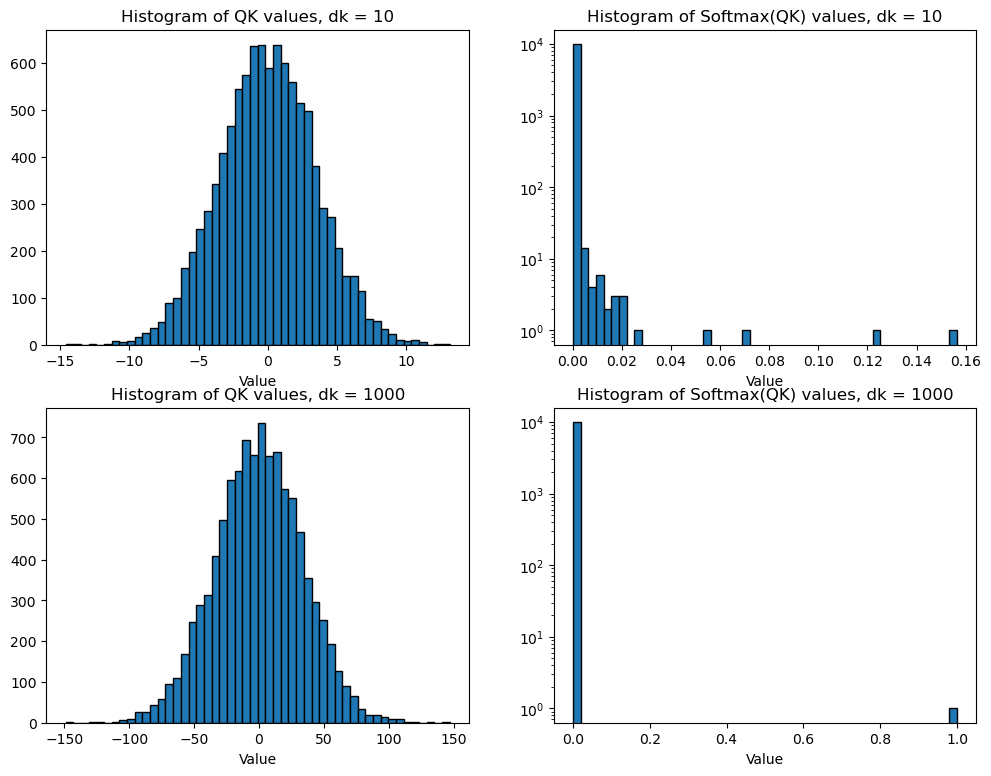

In [9]:
import matplotlib.pyplot as plt
# Set dimensions
dk = [10, 1000]
Nout = 10000

fig, axes = plt.subplots(nrows=len(dk), ncols=2, figsize=(12,9))
for i,d in enumerate(dk):
    Q = np.random.randn(d)
    K = np.random.randn(d, Nout)
    dot = Q @ K
    soft = softmax(dot)
    axes[i, 0].hist(dot, bins=50, edgecolor='black')
    axes[i, 0].set_title(f'Histogram of QK values, dk = {d}')
    axes[i, 0].set_xlabel('Value')
    axes[i, 1].hist(soft, bins=50, edgecolor='black')
    axes[i, 1].set_title(f'Histogram of Softmax(QK) values, dk = {d}')
    axes[i, 1].set_yscale('log')
    axes[i, 1].set_xlabel('Value')
plt.show()

Now after scaling by $\sqrt{d_k}$:

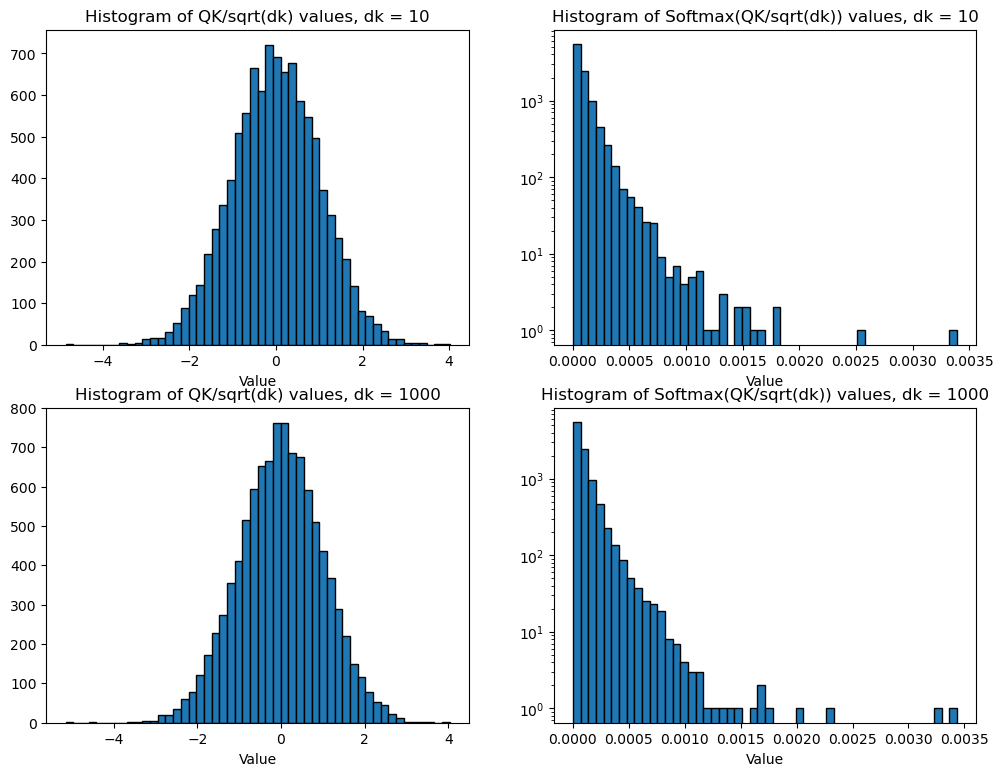

In [10]:
fig, axes = plt.subplots(nrows=len(dk), ncols=2, figsize=(12,9))
for i,d in enumerate(dk):
    Q = np.random.randn(d)
    K = np.random.randn(d, Nout)
    dot = Q @ K / np.sqrt(d)
    soft = softmax(dot)
    axes[i, 0].hist(dot, bins=50, edgecolor='black')
    axes[i, 0].set_title(f'Histogram of QK/sqrt(dk) values, dk = {d}')
    axes[i, 0].set_xlabel('Value')
    axes[i, 1].hist(soft, bins=50, edgecolor='black')
    axes[i, 1].set_title(f'Histogram of Softmax(QK/sqrt(dk)) values, dk = {d}')
    axes[i, 1].set_yscale('log')
    axes[i, 1].set_xlabel('Value')
plt.show()

## Concluding remarks

We've now gotten a taste of modern language modeling, where we've seen that without encoding any explicit structure and rules, a fully data-driven, task-oriented language model like Word2Vec can automatically generate latent structure that shows surprising correlation between linear algebraic (mathematical) properties and semantic structure. We then got a taste of how modern language models can leverage latent vectors to generate outputs that encode context.

Before we conclude this case study, a crucial warning when dealing with data-driven models is that they are **not smart**, and will not magically learn to avoid bias and harmful associations without very hard work from their human designers. This remains a critical open problem in the age of ChatGPT (cf. [AI alignment](https://en.wikipedia.org/wiki/AI_alignment)). Therefore, one should be extremely mindful of how the data might shape the model in ways that might lead to unintended or unexpected behavior, such as the failure cases from above. As an example, despite the fact that our model was trained on a rather sanitary dataset (Wikipedia and news articles), we see that gender biases (whether benign or not) are inherited.

In [11]:
print("Similarity('man', 'nurse'):", 
      cos_sim(latent_vectors['man'], latent_vectors['nurse']))
print("Similarity('woman', 'nurse'):", 
      cos_sim(latent_vectors['woman'], latent_vectors['nurse']))

print("Similarity('he', 'leader'):", 
      cos_sim(latent_vectors['he'], latent_vectors['leader']))
print("Similarity('she', 'leader'):", 
      cos_sim(latent_vectors['she'], latent_vectors['leader']))

Similarity('man', 'nurse'): 0.57187027
Similarity('woman', 'nurse'): 0.715502
Similarity('he', 'leader'): 0.5519083
Similarity('she', 'leader'): 0.39479816
